# Introduction to obspy

The obspy package is very useful to download seismic data and to do some signal processing on them. Most signal processing methods are based on the signal processing method in the Python package scipy.

First we import useful packages.

In [1]:
import obspy
import obspy.clients.earthworm.client as earthworm
import obspy.clients.fdsn.client as fdsn
from obspy import read
from obspy import read_inventory
from obspy import UTCDateTime
from obspy.core.stream import Stream
from obspy.signal.cross_correlation import correlate

import matplotlib.pyplot as plt
import numpy as np
import os
import urllib.request

%matplotlib inline

We are going to download data from an array of seismic stations.

In [2]:
network = 'XU'
arrayName = 'BS'
staNames = ['BS01', 'BS02', 'BS03', 'BS04', 'BS05', 'BS06', 'BS11', 'BS20', 'BS21', 'BS22', 'BS23', 'BS24', 'BS25', \
    'BS26', 'BS27']
chaNames = ['SHE', 'SHN', 'SHZ']
staCodes = 'BS01,BS02,BS03,BS04,BS05,BS06,BS11,BS20,BS21,BS22,BS23,BS24,BS25,BS26,BS27'
chans = 'SHE,SHN,SHZ'

We also need to define the time period for which we want to download data.

In [3]:
myYear = 2010
myMonth = 8
myDay = 17
myHour = 6
TDUR = 2 * 3600.0
Tstart = UTCDateTime(year=myYear, month=myMonth, day=myDay, hour=myHour)
Tend = Tstart + TDUR

We start by defining the client for downloading the data

In [4]:
fdsn_client = fdsn.Client('IRIS')

Download the seismic data for all the stations in the array.

In [5]:
Dtmp = fdsn_client.get_waveforms(network=network, station=staCodes, location='--', channel=chans, starttime=Tstart, \
    endtime=Tend, attach_response=True)

Some stations did not record the entire two hours. We delete these and keep only stations with a complte two hour recording.

In [6]:
ntmp = []
for ksta in range(0, len(Dtmp)):
    ntmp.append(len(Dtmp[ksta]))
ntmp = max(set(ntmp), key=ntmp.count)
D = Dtmp.select(npts=ntmp)

This is a function for plotting after each operation on the data.

In [7]:
def plot_2hour(D, channel, offset, title):
    """ Plot seismograms
        D = Stream
        channel = 'E', 'N', or 'Z'
        offset = Offset between two stations
        title = Title of the figure
    """
    fig, ax = plt.subplots(figsize=(15, 10))
    Dplot = D.select(component=channel)
    t = (1.0 / Dplot[0].stats.sampling_rate) * np.arange(0, Dplot[0].stats.npts)
    for ksta in range(0, len(Dplot)):
        plt.plot(t, ksta * offset + Dplot[ksta].data, 'k')
    plt.xlim(np.min(t), np.max(t))
    plt.ylim(- offset, len(Dplot) * offset)
    plt.title(title, fontsize=24)
    plt.xlabel('Time (s)', fontsize=24)
    ax.set_yticklabels([])
    ax.tick_params(labelsize=20)

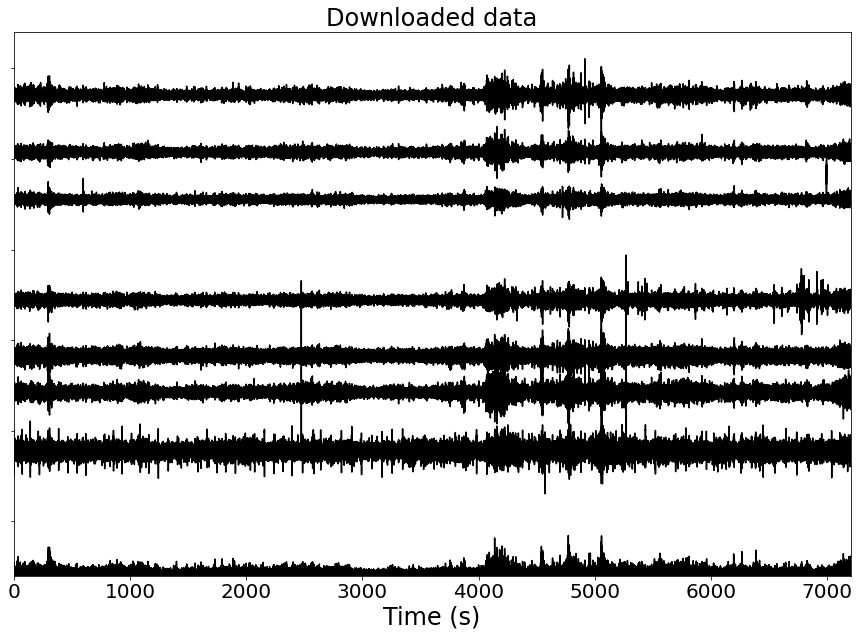

In [8]:
plot_2hour(D, 'E', 1200.0, 'Downloaded data')

We start by detrending the data.

In [9]:
D

27 Trace(s) in Stream:

XU.BS01..SHE | 2010-08-17T06:00:00.000000Z - 2010-08-17T08:00:00.000000Z | 50.0 Hz, 360001 samples
...
(25 other traces)
...
XU.BS27..SHZ | 2010-08-17T06:00:00.000000Z - 2010-08-17T08:00:00.000000Z | 50.0 Hz, 360001 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

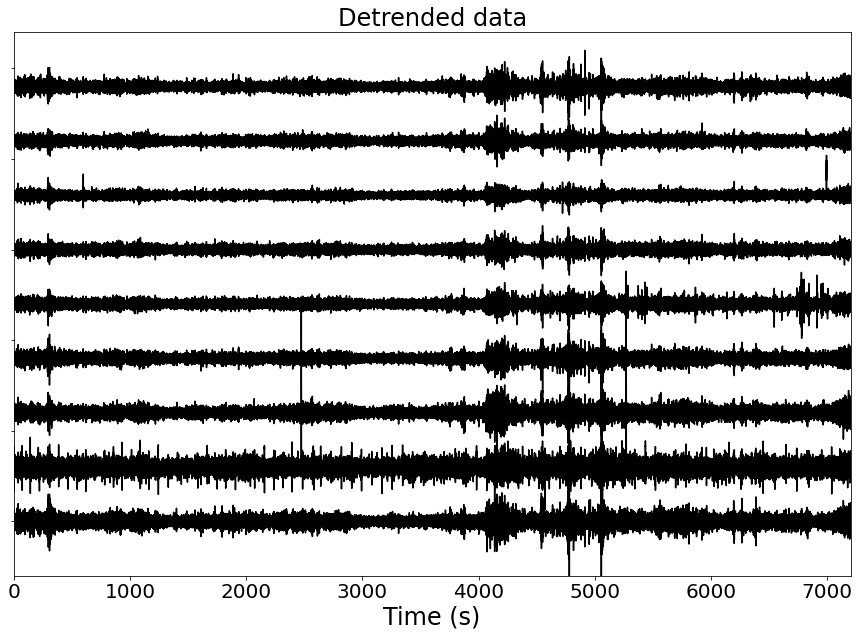

In [10]:
D.detrend(type='linear')
plot_2hour(D, 'E', 1200.0, 'Detrended data')

We then taper the data.

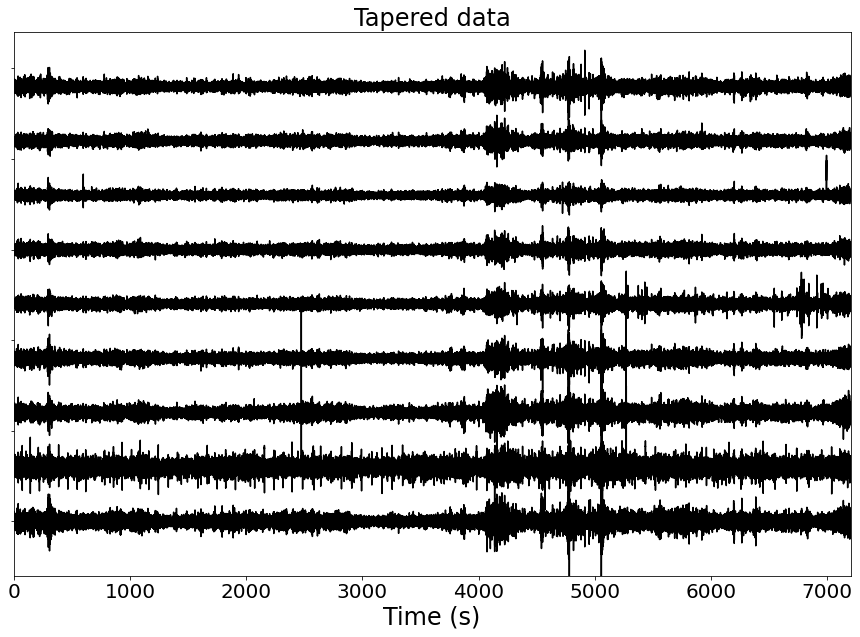

In [11]:
D.taper(type='hann', max_percentage=None, max_length=5.0)
plot_2hour(D, 'E', 1200.0, 'Tapered data')

And we remove the instrment response.

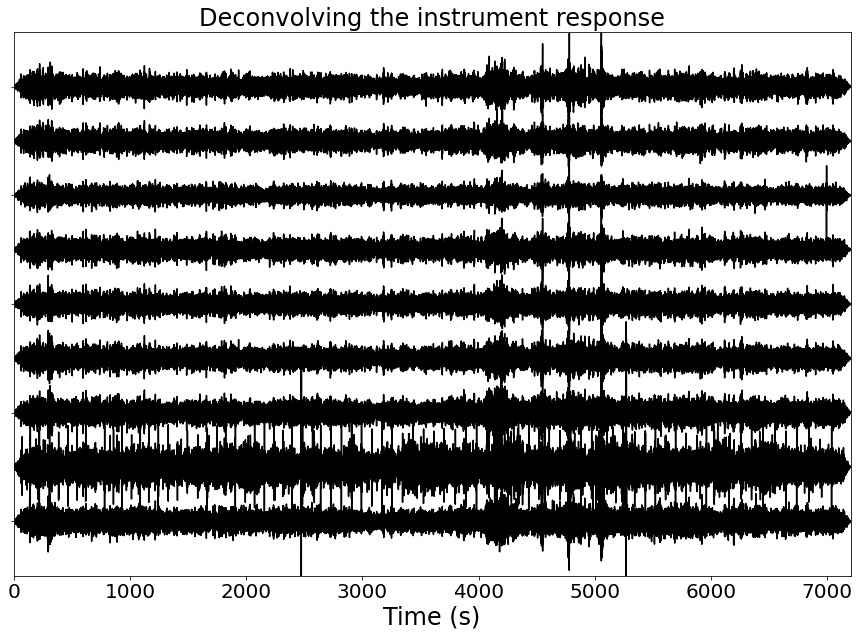

In [12]:
D.remove_response(output='VEL', pre_filt=(0.2, 0.5, 10.0, 15.0), water_level=80.0)
plot_2hour(D, 'E', 1.0e-6, 'Deconvolving the instrument response')

Then we filter the data.

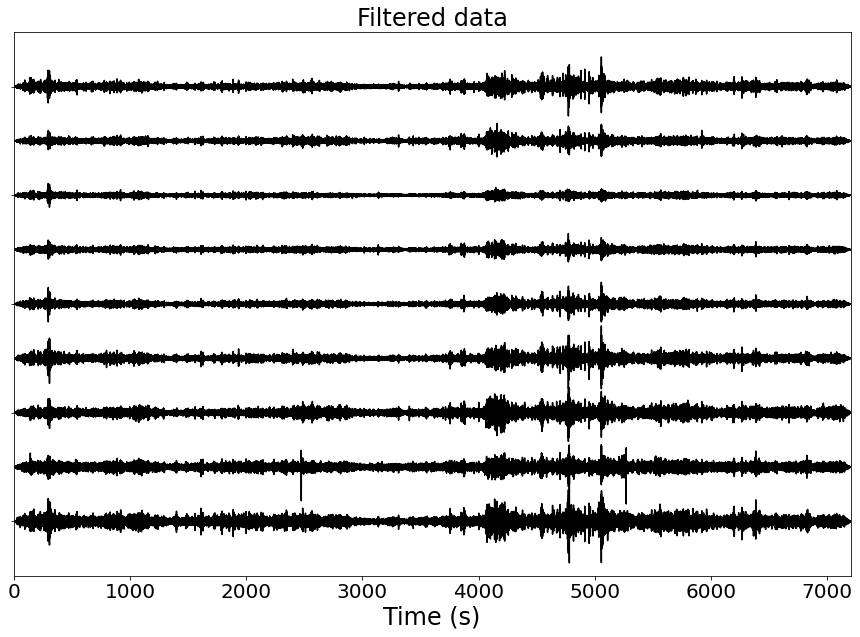

In [13]:
D.filter('bandpass', freqmin=2.0, freqmax=8.0, zerophase=True)
plot_2hour(D, 'E', 1.0e-6, 'Filtered data')

And we resample the data.

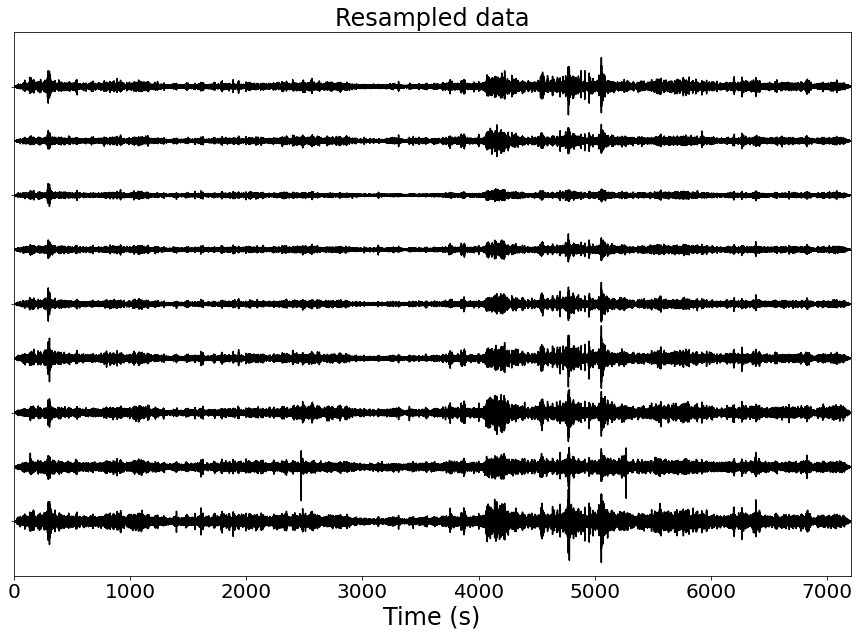

In [14]:
D.interpolate(100.0, method='lanczos', a=10)
D.decimate(5, no_filter=True)
plot_2hour(D, 'E', 1.0e-6, 'Resampled data')

We can also compute the envelope of the signal.

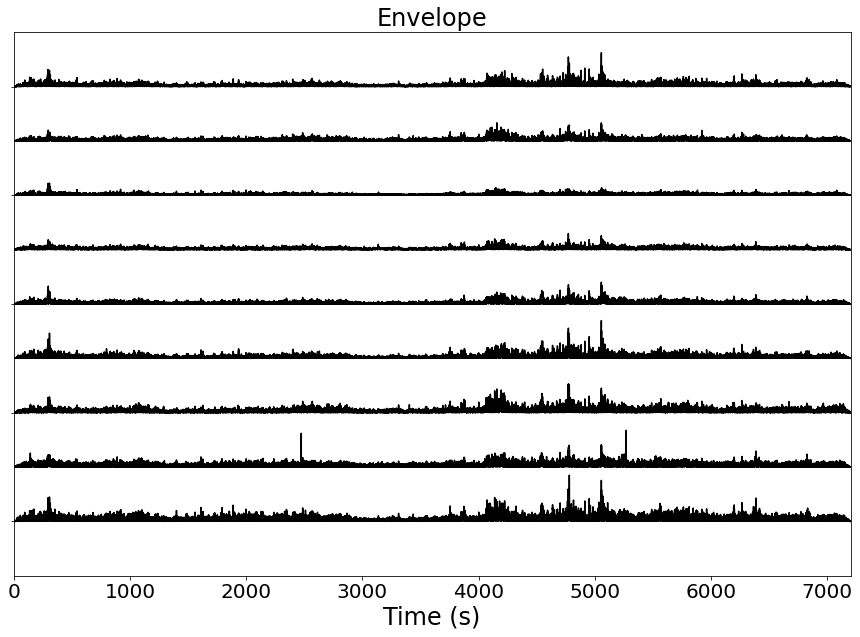

In [15]:
for index in range(0, len(D)):
    D[index].data = obspy.signal.filter.envelope(D[index].data)
plot_2hour(D, 'E', 1.0e-6, 'Envelope')

You can also download the instrument response separately:

In [16]:
network = 'XQ'
station = 'ME12'
channels = 'BHE,BHN,BHZ'
location = '01'

This is to download the instrument response.

In [17]:
fdsn_client = fdsn.Client('IRIS')
inventory = fdsn_client.get_stations(network=network, station=station, level='response')
inventory.write('response/' + network + '_' + station + '.xml', format='STATIONXML')

We then read the data and start precessing the signal as we did above.

In [18]:
fdsn_client = fdsn.Client('IRIS')
Tstart = UTCDateTime(year=2008, month=4, day=1, hour=4, minute=49)
Tend = UTCDateTime(year=2008, month=4, day=1, hour=4, minute=50)
D = fdsn_client.get_waveforms(network=network, station=station, location=location, channel=channels, starttime=Tstart, endtime=Tend, attach_response=False)
D.detrend(type='linear')
D.taper(type='hann', max_percentage=None, max_length=5.0)

3 Trace(s) in Stream:
XQ.ME12.01.BHE | 2008-04-01T04:49:00.015000Z - 2008-04-01T04:49:59.990000Z | 40.0 Hz, 2400 samples
XQ.ME12.01.BHN | 2008-04-01T04:49:00.015000Z - 2008-04-01T04:49:59.990000Z | 40.0 Hz, 2400 samples
XQ.ME12.01.BHZ | 2008-04-01T04:49:00.015000Z - 2008-04-01T04:49:59.990000Z | 40.0 Hz, 2400 samples

But we now use the xml file that contains the instrment response to remove it from the signal.

In [19]:
filename = 'response/' + network + '_' + station + '.xml'
inventory = read_inventory(filename, format='STATIONXML')
D.attach_response(inventory)
D.remove_response(output='VEL', pre_filt=(0.2, 0.5, 10.0, 15.0), water_level=80.0)

3 Trace(s) in Stream:
XQ.ME12.01.BHE | 2008-04-01T04:49:00.015000Z - 2008-04-01T04:49:59.990000Z | 40.0 Hz, 2400 samples
XQ.ME12.01.BHN | 2008-04-01T04:49:00.015000Z - 2008-04-01T04:49:59.990000Z | 40.0 Hz, 2400 samples
XQ.ME12.01.BHZ | 2008-04-01T04:49:00.015000Z - 2008-04-01T04:49:59.990000Z | 40.0 Hz, 2400 samples

We resume signal processing.

In [20]:
D.filter('bandpass', freqmin=2.0, freqmax=8.0, zerophase=True)
D.interpolate(100.0, method='lanczos', a=10)
D.decimate(5, no_filter=True)

3 Trace(s) in Stream:
XQ.ME12.01.BHE | 2008-04-01T04:49:00.015000Z - 2008-04-01T04:49:59.965000Z | 20.0 Hz, 1200 samples
XQ.ME12.01.BHN | 2008-04-01T04:49:00.015000Z - 2008-04-01T04:49:59.965000Z | 20.0 Hz, 1200 samples
XQ.ME12.01.BHZ | 2008-04-01T04:49:00.015000Z - 2008-04-01T04:49:59.965000Z | 20.0 Hz, 1200 samples

And we plot.

Text(0.5, 0, 'Time (s)')

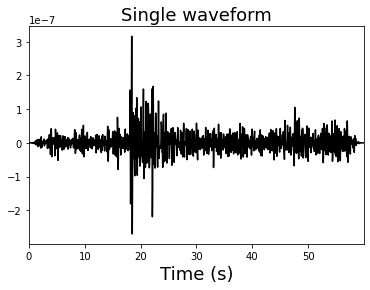

In [21]:
t = (1.0 / D[0].stats.sampling_rate) * np.arange(0, D[0].stats.npts)
plt.plot(t, D[0].data, 'k')
plt.xlim(np.min(t), np.max(t))
plt.title('Single waveform', fontsize=18)
plt.xlabel('Time (s)', fontsize=18)

Not all seismic data are stored on IRIS. This is an example of how to download data from the Northern California Earthquake Data Center (NCEDC).

In [22]:
network = 'BK'
station = 'WDC'
channels = 'BHE,BHN,BHZ'
location = '--'

This is to download the instrument response.

In [23]:
url = 'http://service.ncedc.org/fdsnws/station/1/query?net=' + network + '&sta=' + station + '&level=response&format=xml&includeavailability=true'
s = urllib.request.urlopen(url)
contents = s.read()
file = open('response/' + network + '_' + station + '.xml', 'wb')
file.write(contents)
file.close()

And this is to download the data.

In [24]:
Tstart = UTCDateTime(year=2007, month=2, day=12, hour=1, minute=11, second=54)
Tend = UTCDateTime(year=2007, month=2, day=12, hour=1, minute=12, second=54)
request = 'waveform_' + station + '.request'
file = open(request, 'w')
message = '{} {} {} {} '.format(network, station, location, channels) + \
    '{:04d}-{:02d}-{:02d}T{:02d}:{:02d}:{:02d} '.format( \
    Tstart.year, Tstart.month, Tstart.day, Tstart.hour, Tstart.minute, Tstart.second) + \
    '{:04d}-{:02d}-{:02d}T{:02d}:{:02d}:{:02d}\n'.format( \
    Tend.year, Tend.month, Tend.day, Tend.hour, Tend.minute, Tend.second)
file.write(message)
file.close()
miniseed = 'station_' + station + '.miniseed'
request = 'curl -s --data-binary @waveform_' + station + '.request -o ' + miniseed + ' http://service.ncedc.org/fdsnws/dataselect/1/query'
os.system(request)
D = read(miniseed)
D.detrend(type='linear')
D.taper(type='hann', max_percentage=None, max_length=5.0)

3 Trace(s) in Stream:
BK.WDC..BHE | 2007-02-12T01:11:54.010645Z - 2007-02-12T01:12:53.985645Z | 40.0 Hz, 2400 samples
BK.WDC..BHN | 2007-02-12T01:11:54.010645Z - 2007-02-12T01:12:53.985645Z | 40.0 Hz, 2400 samples
BK.WDC..BHZ | 2007-02-12T01:11:54.010645Z - 2007-02-12T01:12:53.985645Z | 40.0 Hz, 2400 samples

In [25]:
filename = 'response/' + network + '_' + station + '.xml'
inventory = read_inventory(filename, format='STATIONXML')
D.attach_response(inventory)
D.remove_response(output='VEL', pre_filt=(0.2, 0.5, 10.0, 15.0), water_level=80.0)

3 Trace(s) in Stream:
BK.WDC..BHE | 2007-02-12T01:11:54.010645Z - 2007-02-12T01:12:53.985645Z | 40.0 Hz, 2400 samples
BK.WDC..BHN | 2007-02-12T01:11:54.010645Z - 2007-02-12T01:12:53.985645Z | 40.0 Hz, 2400 samples
BK.WDC..BHZ | 2007-02-12T01:11:54.010645Z - 2007-02-12T01:12:53.985645Z | 40.0 Hz, 2400 samples

In [26]:
D.filter('bandpass', freqmin=2.0, freqmax=8.0, zerophase=True)
D.interpolate(100.0, method='lanczos', a=10)
D.decimate(5, no_filter=True)

3 Trace(s) in Stream:
BK.WDC..BHE | 2007-02-12T01:11:54.010645Z - 2007-02-12T01:12:53.960645Z | 20.0 Hz, 1200 samples
BK.WDC..BHN | 2007-02-12T01:11:54.010645Z - 2007-02-12T01:12:53.960645Z | 20.0 Hz, 1200 samples
BK.WDC..BHZ | 2007-02-12T01:11:54.010645Z - 2007-02-12T01:12:53.960645Z | 20.0 Hz, 1200 samples

Text(0.5, 0, 'Time (s)')

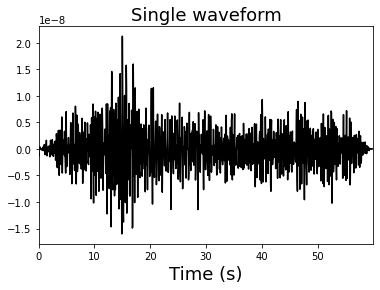

In [27]:
t = (1.0 / D[0].stats.sampling_rate) * np.arange(0, D[0].stats.npts)
plt.plot(t, D[0].data, 'k')
plt.xlim(np.min(t), np.max(t))
plt.title('Single waveform', fontsize=18)
plt.xlabel('Time (s)', fontsize=18)